In [1]:
import pandas as pd
import pickle
from pathlib import Path
from collections import namedtuple
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib inline

# Display more rows and get rid of the margins
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Display mulitiple values from each cell
# https://stackoverflow.com/a/42476224
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
from abcd_helpers import resproc as rp

In [3]:
data_dir = Path('data')
swarm_out_dir = Path('bootstrap_test/single_runs')
data_out_dir = Path('bootstrap_test')

# Load Data

In [4]:
# Either load consolidated permutation results or load individual permuatation pkzs and consolidate them
con_mod_res_path = data_out_dir/'con_mod_separate_1000.pkz'
var_res_path = data_out_dir/'var_res_separate_1000.pkz'
cb_var_res_path = data_out_dir/'cb_var_res_separate_1000.pkz'

try:
    con_mod_res = pd.read_pickle(con_mod_res_path)
    var_res = pd.read_pickle(var_res_path).reset_index(drop=True)
    cb_var_res = pd.read_pickle(cb_var_res_path).reset_index(drop=True)
except (FileNotFoundError, EOFError):
    con_pks = sorted(list(swarm_out_dir.glob('pn-*_con*.pkz')))
    con_mod_res = []
    var_res = []
    cb_var_res = []
    for pk in con_pks:
        with open(pk, 'rb') as h:
            pkr = pickle.load(h)
        con_mod_res.append(pd.DataFrame(pkr[0]))
        var_res.append(pd.DataFrame(pkr[1]))
        cb_var_res.append(pd.DataFrame(pkr[2]))
    con_mod_res = pd.concat(con_mod_res, ignore_index=True)
    var_res = pd.concat(var_res, ignore_index=True)
    cb_var_res = pd.concat(cb_var_res, ignore_index=True)
    #con_mod_res.to_pickle(con_mod_res_path)
    #var_res.to_pickle(var_res_path)
    #cb_var_res.to_pickle(cb_var_res_path)
    

var_res = rp.get_varex(var_res)
cb_var_res = rp.get_varex(cb_var_res)



In [5]:
    bs_con_pks = sorted(list(swarm_out_dir.glob('bs-*_con*.pkz')))
    bs_con_mod_res = []
    bs_var_res = []
    bs_cb_var_res = []
    for ii, pk in enumerate(bs_con_pks):
        with open(pk, 'rb') as h:
            pkr = pickle.load(h)
        bs_con_mod_res.append(pd.DataFrame(pkr[0]))
        bs_var_res.append(pd.DataFrame(pkr[1]))
        bs_cb_var_res.append(pd.DataFrame(pkr[2]))
    bs_con_mod_res = pd.concat(bs_con_mod_res, ignore_index=True)
    bs_var_res = pd.concat(bs_var_res, ignore_index=True)
    bs_cb_var_res = pd.concat(bs_cb_var_res, ignore_index=True)
    #con_mod_res.to_pickle(con_mod_res_path)
    #var_res.to_pickle(var_res_path)
    #cb_var_res.to_pickle(cb_var_res_path)
#var_res['int_r2'] = 0    
bs_var_res = rp.get_varex(bs_var_res)
#cb_var_res['int_r2'] = 0 
bs_cb_var_res = rp.get_varex(bs_cb_var_res)

In [6]:
alpha = 0.005
qup = 1 - (alpha/2)
qdn = (alpha/2)
bs_var_res, bs_dif_sig = rp.get_sig_var_difs(alpha, bs_var_res, bs_cb_var_res, verbose=True)
cor_p = multipletests(bs_dif_sig.uncorrected_p.values,method='sidak', alpha=alpha)
bs_dif_sig['p'] = cor_p[1]
bs_dif_sig['sig'] = cor_p[0]

Beginning processing metric 0 of 416


/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Completed 50 metrics.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Completed 100 metrics.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, returning empirical cdf based p.
Could not fit GPD to tail of distribution, 

In [101]:
bs_var_res.to_pickle('bs_var_res_con.pkz.gz')

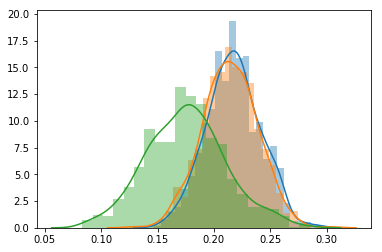

In [7]:
# Get difference in accuracies via bootstrap

bs_con_mod_res.loc[(bs_con_mod_res.name == 'normal') | (bs_con_mod_res.name == 'combat'), 'bal_proc'] = 'sex'
bs_con_mod_res.loc[(bs_con_mod_res.name == 'age_rsd') | (bs_con_mod_res.name == 'cbagersd'), 'bal_proc'] = 'age_rsd'
bs_con_mod_res.loc[(bs_con_mod_res.name == 'ab_normal') | (bs_con_mod_res.name == 'ab_combat'), 'bal_proc'] = 'age_bal'
bs_con_mod_res.loc[:, 'combat'] = False
bs_con_mod_res.loc[((bs_con_mod_res.name == 'combat') 
                    | (bs_con_mod_res.name == 'cbagersd') 
                    | (bs_con_mod_res.name == 'ab_combat')), 'combat'] = True

bs_collapse = (bs_con_mod_res
               .query('~combat')
               .loc[:, ['bal_proc', 'pn', 'fn', 'ho_score']]
               .merge(bs_con_mod_res
                      .query('combat')
                      .loc[:, ['bal_proc', 'pn', 'fn', 'ho_score']],
                      on=['bal_proc', 'pn', 'fn'],
                      how='left',
                      suffixes=('_uncorrected', '_combat')))
bs_collapse['difference'] = bs_collapse.ho_score_uncorrected - bs_collapse.ho_score_combat

sns.distplot(bs_collapse.query('bal_proc == "sex"').difference.values)
sns.distplot(bs_collapse.query('bal_proc == "age_rsd"').difference.values)
sns.distplot(bs_collapse.query('bal_proc == "age_bal"').difference.values)

# Generate plots of variance explained
## First we'll make the rediculously big and detailed plot that is destined for the appendix

In [8]:
alpha = 0.005
qup = 1 - (alpha/2)
qdn = (alpha/2)

In [9]:
# Create the paper context
sns.set_context('paper',font_scale = 0.8 )
sns.set_style('white')


# Get significance threshold for percent variance explained
varexes = ['agh_varex','mfg_varex','model_varex','site_varex']
sig_df = var_res.groupby('pn')[varexes].max().quantile([qup]).iloc[0, :]
cb_sig_df =cb_var_res.groupby('pn')[varexes].max().quantile([qup]).iloc[0, :]
sig_df['modality'] = "rsfmri"
cb_sig_df['modality'] = "rsfmri"

to_plot = var_res.merge(cb_var_res.loc[:,['pn','metric','agh_varex','mfg_varex','model_varex','site_varex']], on = ['pn','metric'], suffixes=('','_cb')).query('pn==0')
to_plot['label'] = to_plot.metric.str.replace('lh', 'l').str.replace('rh', 'r').str.replace('rsfmri_cor_', '').str.replace('network.gordon_', '').str.replace('network.gordon_', '').str.replace('subcort.aseg_', '').str.replace('.', ' ').str.title().str.split('_').str.join('-')


cm_ind = (to_plot.mfg_varex >= sig_df.mfg_varex) | (to_plot.model_varex >= sig_df.model_varex) | (to_plot.site_varex >= sig_df.site_varex)
# Look at the number of metrics that have significant
# variance accounted for by mfg, model, or site
print(f"{cm_ind.sum()} metrics have significant variance accounted for by manufactuerer, model, or site")

# Look at the list of significant metrics
to_plot.loc[cm_ind, ['metric', 'label']]

# Clean up column names for plotting
to_plot_rn = {'mfg_varex': 'Manufacturer',
              'model_varex': 'Model',
              'site_varex': 'Site',
              'agh_varex': 'Age & Sex'}
sig_df_rn = {'mfg_varex': 'Manufacturer',
             'model_varex': 'Model',
             'site_varex': 'Site',
             'agh_varex': 'Age & Sex'}
cb_sig_df_rn = {'mfg_varex': 'mfg_varex_cb',
                'model_varex': 'model_varex_cb',
                'site_varex': 'site_varex_cb',
                'agh_varex': 'agh_varex_cb'}
to_plot = to_plot.loc[cm_ind,:].rename(columns=to_plot_rn)
to_plot_sig = sig_df.rename(index=sig_df_rn)
to_plot_sig_cb = cb_sig_df.rename(index=cb_sig_df_rn)

# Define factors
varex_factors = ['Manufacturer','Model','Site','Age & Sex']
cb_factors = ['mfg_varex_cb','model_varex_cb','site_varex_cb','agh_varex_cb']

# Create sort key
to_plot['sort_key'] = np.nan
sort_vars = ['Manufacturer','Model','Site']
remain_max = 0
for i, sv in enumerate(sort_vars[::-1]):
    remain_max += to_plot.loc[:,sort_vars[::-1][i:]].values.max()+1
    skind = ((to_plot[sv] > to_plot_sig[sv]))
    to_plot.loc[skind, 'sort_key'] = to_plot.loc[skind,sv] + remain_max

    
# Make bar lists for uncorrected and combat corrected data
uncorlist = rp.make_bar_list(varex_factors, to_plot, to_plot_sig,
                          cols = 3,
                          sort_var='sort_key', sig_exclude=['Age & Sex'])
uncorlist
left_start = [28, 28, 28]
cblist = rp.make_bar_list(cb_factors, to_plot, to_plot_sig_cb,
                       left_start = left_start,
                       cols = 3,
                       sort_var='sort_key', sig_exclude=['agh_varex_cb'])

210 metrics have significant variance accounted for by manufactuerer, model, or site


,metric,label
0,rsfmri_cor_network.gordon_auditory_network.gordon_auditory,Auditory-Auditory
1,rsfmri_cor_network.gordon_auditory_network.gordon_cingulooperc,Auditory-Cingulooperc
3,rsfmri_cor_network.gordon_auditory_network.gordon_default,Auditory-Default
5,rsfmri_cor_network.gordon_auditory_network.gordon_frontoparietal,Auditory-Frontoparietal
8,rsfmri_cor_network.gordon_auditory_network.gordon_smhand,Auditory-Smhand
9,rsfmri_cor_network.gordon_auditory_network.gordon_smmouth,Auditory-Smmouth
12,rsfmri_cor_network.gordon_auditory_network.gordon_visual,Auditory-Visual
13,rsfmri_cor_network.gordon_cingulooperc_network.gordon_auditory,Cingulooperc-Auditory
14,rsfmri_cor_network.gordon_cingulooperc_network.gordon_cingulooperc,Cingulooperc-Cingulooperc
15,rsfmri_cor_network.gordon_cingulooperc_network.gordon_cinguloparietal,Cingulooperc-Cinguloparietal


[       y      width  left  \
 0      0   0.190460   0.0   
 1      1   1.110231   0.0   
 2      2   1.110231   0.0   
 3      3   1.126944   0.0   
 4      4   0.717791   0.0   
 5      5   0.786425   0.0   
 6      6   0.187978   0.0   
 7      7   1.073173   0.0   
 8      8   0.369042   0.0   
 9      9   0.369042   0.0   
 10    10   1.130489   0.0   
 11    11   1.084863   0.0   
 12    12   0.665334   0.0   
 13    13   0.665334   0.0   
 14    14   0.820316   0.0   
 15    15   1.111219   0.0   
 16    16   0.884392   0.0   
 17    17   0.195349   0.0   
 18    18   0.976378   0.0   
 19    19   0.429206   0.0   
 20    20   0.297730   0.0   
 21    21   0.297730   0.0   
 22    22   0.787163   0.0   
 23    23   0.519198   0.0   
 24    24   1.196941   0.0   
 25    25   1.196941   0.0   
 26    26   1.228179   0.0   
 27    27   1.230889   0.0   
 28    28   1.230889   0.0   
 29    29   1.233321   0.0   
 30    30   1.237560   0.0   
 31    31   1.242000   0.0   
 32    32 

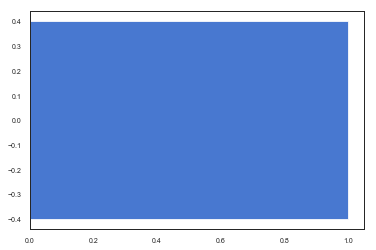

In [10]:
# This is hacky, but in order to get the legend I want,
# I'm creating it here, and then using the object in the actual figure

fig,ax = plt.subplots(1)
sig_palette=sns.color_palette('muted')[0:len(varex_factors)]
palette=sns.color_palette('pastel')[0:len(varex_factors)]
bottom = np.zeros(len(varex_factors)*2)
width = np.ones(len(varex_factors)*2)
leg_labels = []
colors = []
for i,vf in enumerate(varex_factors):
    if 'ag' not in vf.lower():
        colors.append(sig_palette[i])
        leg_labels.append('Sig. '+vf)
    leg_labels.append(vf)
    colors.append(palette[i])
leg_labels[-1] = 'Sex & Age'
# Change name of site to scanner
leg_labels[5] = 'Scanner'
leg_labels[4] = 'Sig. Scanner'
leg_bar = ax.barh(bottom, width, color=colors, label=leg_labels)

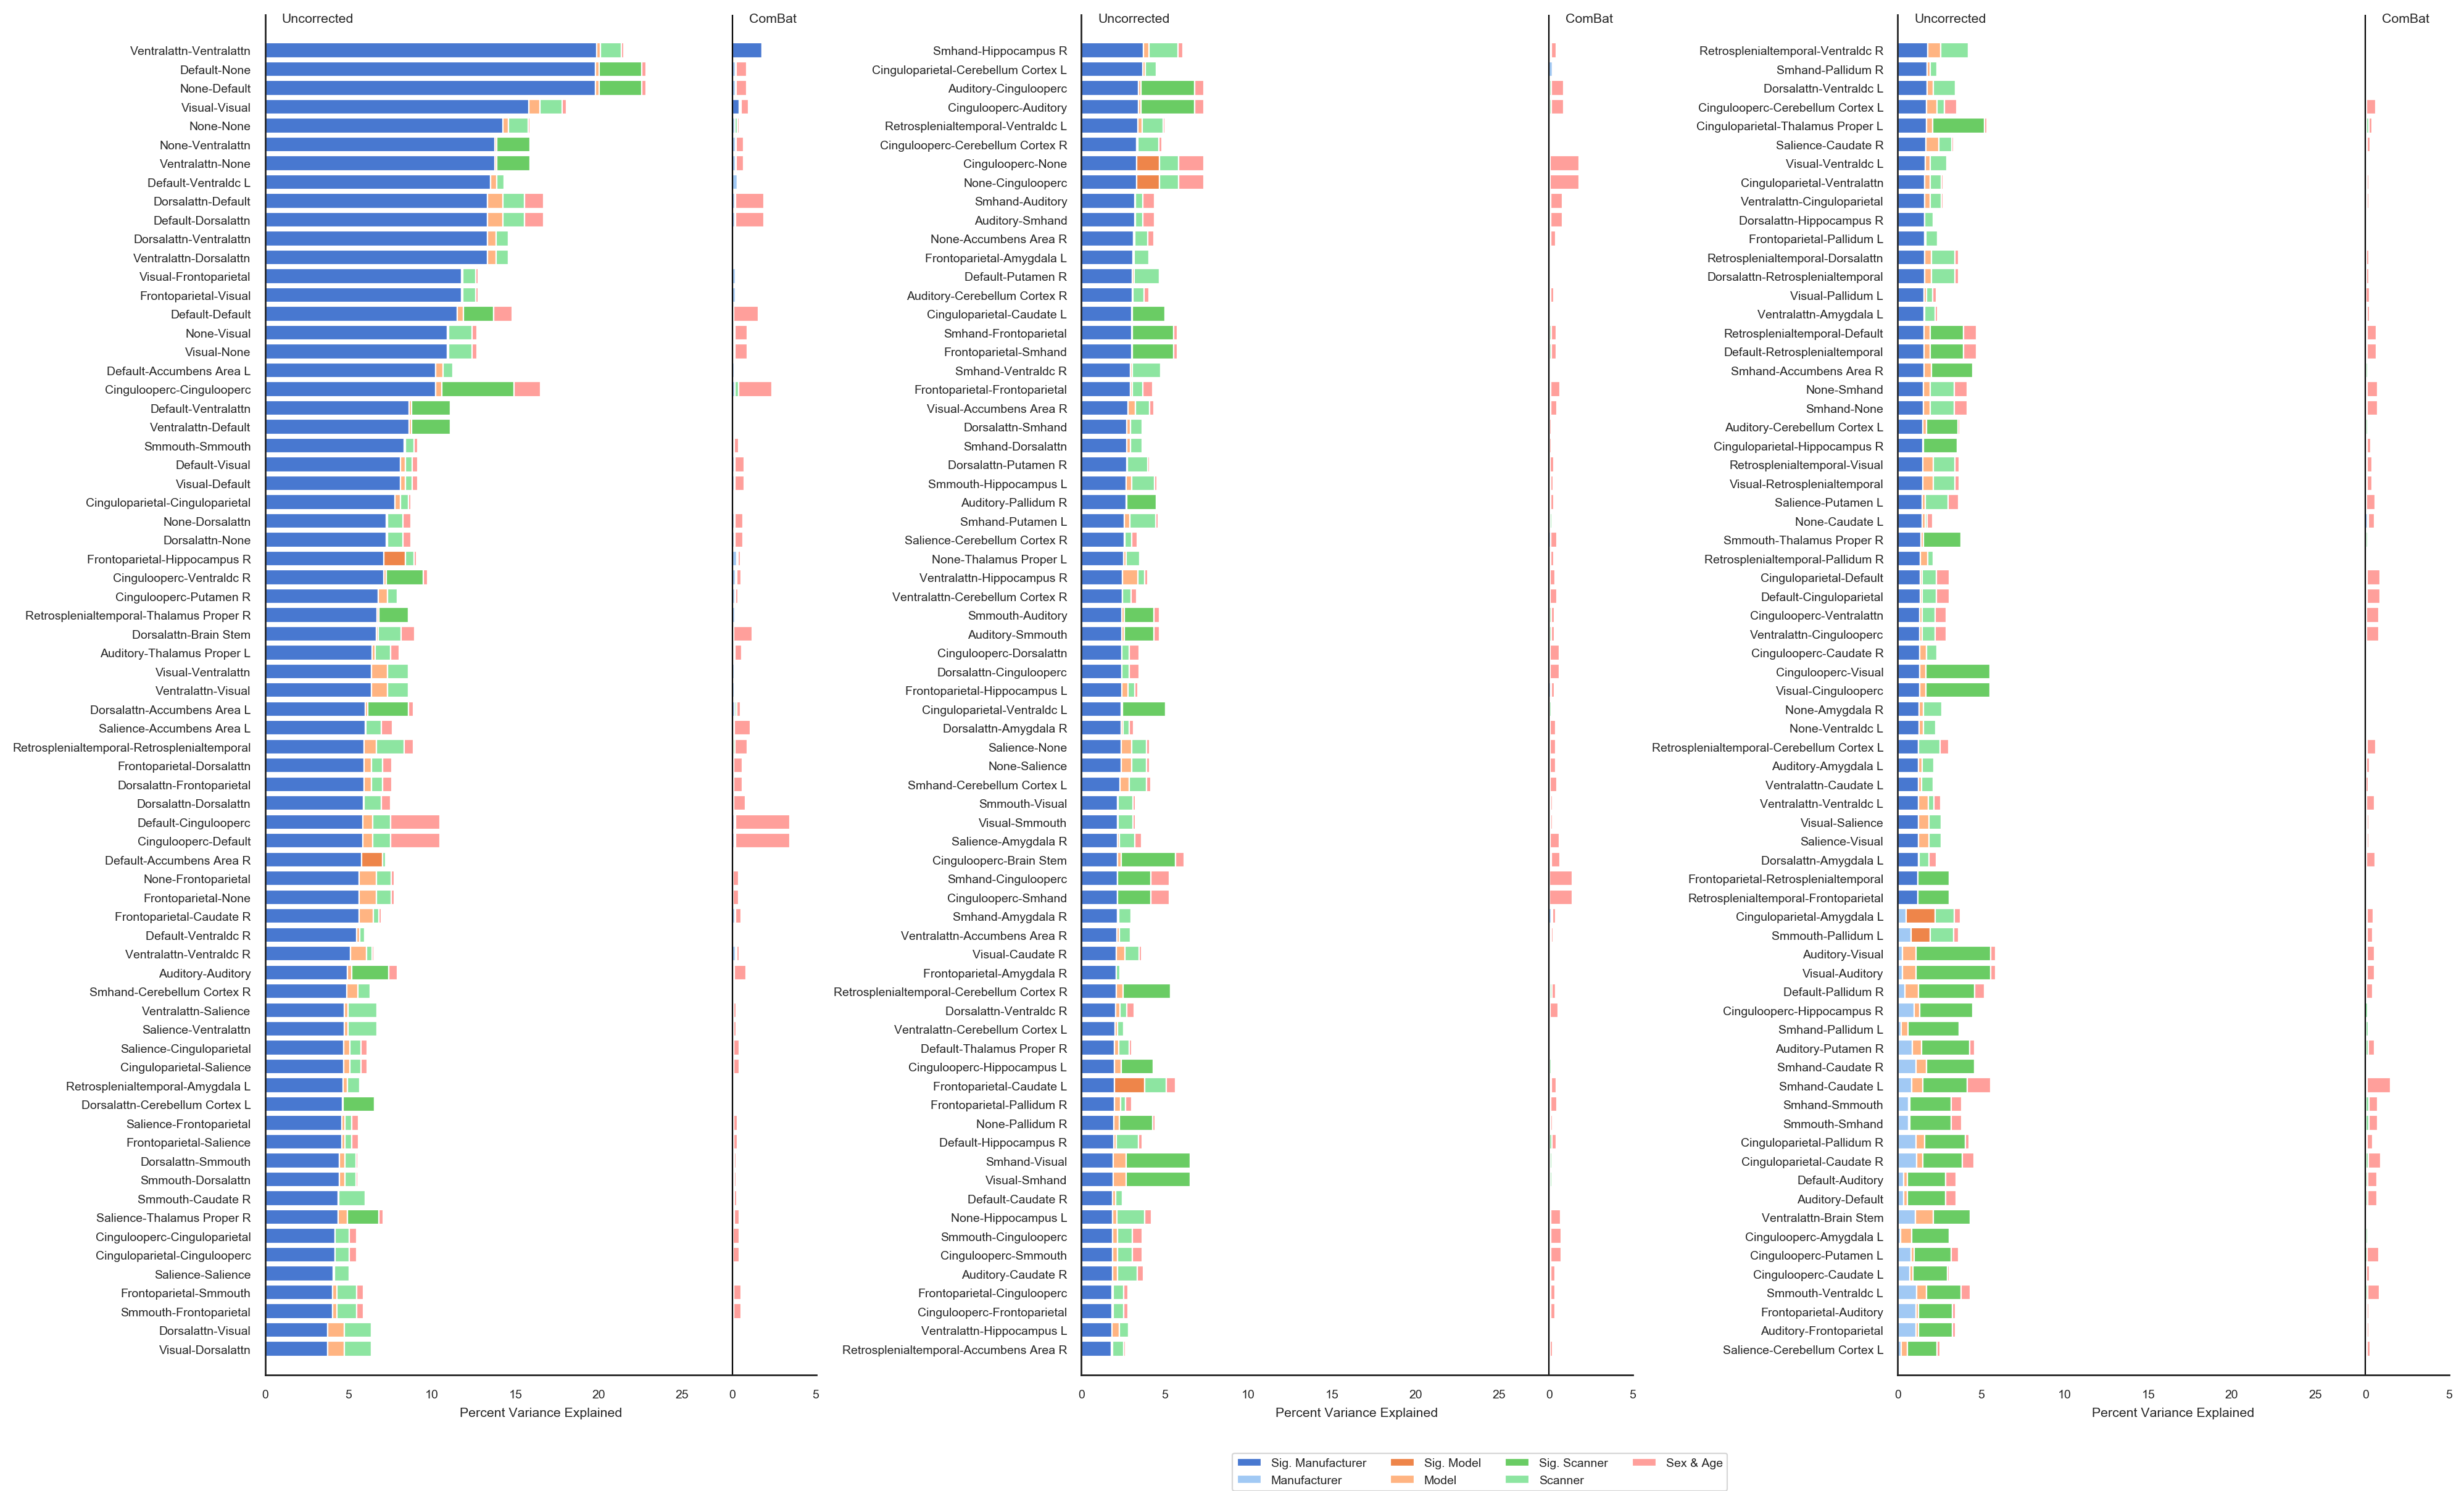

In [11]:

fig, axes = plt.subplots(1, 3, figsize=(20,12), dpi=200)

for col in np.arange(len(axes)):
    ax = axes[col]
    for uc, cb in zip(uncorlist, cblist):
        barh_dict = uc.loc[uc.col == col, ['y', 'color', 'left', 'tick_label', 'width']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['y', 'color', 'left', 'tick_label', 'width']].to_dict('list')

        #names = uc.loc[uc.col == col, ['metric']]
        _plot = ax.barh(**barh_dict)
        _plot = ax.barh(**cb_barh_dict)
    #name_df = uc.loc[uc.col == col, ['bottom', 'metric']].groupby('metric').max().reset_index()
    #for ii, row in name_df.iterrows():
    #    _text = ax.text(11, row.bottom + 1, row.metric, va='bottom', ha='center')
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(left_start[col], yb,yt, lw=0.8)
    _lim = ax.set_ylim((yb,yt))
    left_end = 5
    xticks = np.hstack([np.arange(0,left_start[col], left_end),
                        np.arange(left_start[col],left_start[col] + left_end + 1, left_end)])
    xtick_labels = np.hstack([np.arange(0,left_start[col], left_end),
                        np.arange(0, left_end + 1, left_end)])
    t = ax.set_xticks(xticks)
    _tl = ax.set_xticklabels(xtick_labels)
    _ylims = ax.set_ylim((yb+2.5, yt-2))
    _t = ax.text(1, np.max(barh_dict['y']) + 1.5, 'Uncorrected')
    _t = ax.text(left_start[col] + 1, np.max(barh_dict['y']) + 1.5, 'ComBat')
    _t = ax.set_xlabel('Percent Variance Explained')
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
#         if txt in motion_metrics:
#             _tl = tl.set_weight('bold')
fig.tight_layout()
fig.legend(leg_bar, leg_labels, loc=(0.5,0), ncol=4 )    
fig.subplots_adjust(bottom = 0.07)

sns.despine(fig)

## Now we'll make the distribution plot that will be in the main paper

In [12]:
to_plot_melt = to_plot.loc[:, ['pn', 'metric', 'label', 'Age & Sex', 'Manufacturer', 'Model', 'Site']]
to_plot_melt['modality'] = 'rsfmri'
to_plot_melt = to_plot_melt.melt(id_vars=['pn', 'metric', 'modality', 'label'],
                            value_name='% Variance Explained')
to_plot_melt[' '] = 'Uncorrected'


to_plot_melt_cb = to_plot.loc[:, ['pn','metric', 'label', 'agh_varex_cb', 'mfg_varex_cb', 'model_varex_cb','site_varex_cb']]
to_plot_melt_cb = to_plot_melt_cb.rename(columns = {'agh_varex_cb':'Age & Sex', 
                                          'mfg_varex_cb': 'Manufacturer',
                                          'model_varex_cb': 'Model',
                                          'site_varex_cb': 'Site'})
to_plot_melt_cb['modality'] = 'rsfmri'
to_plot_melt_cb = to_plot_melt_cb.melt(id_vars=['pn', 'metric', 'modality', 'label'],
                            value_name='% Variance Explained')
to_plot_melt_cb[' '] = 'Combat'
to_plot_melt = pd.concat([to_plot_melt,to_plot_melt_cb])

# Reformat sig_dfs to work with plotting code
sig_df = pd.DataFrame(sig_df).T.reset_index(drop=True)
cb_sig_df = pd.DataFrame(cb_sig_df).T.reset_index(drop=True)


[Text(0,0,'Manufacturer'),
 Text(0,0,'Model'),
 Text(0,0,'Site'),
 Text(0,0,'Age & Sex')]

Text(0.5,1,'RSFMRI')

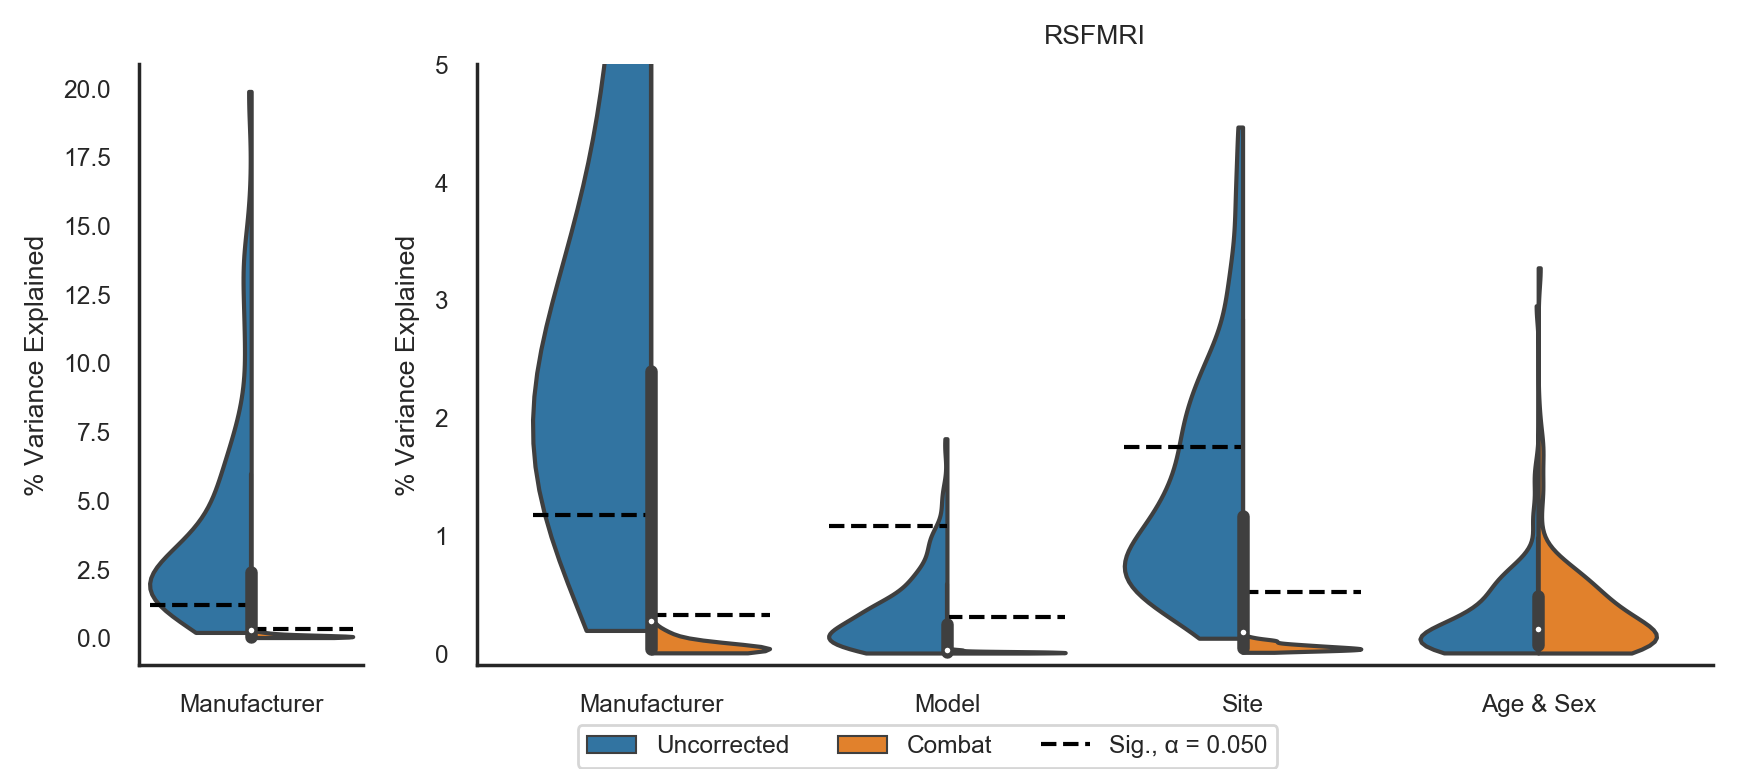

In [48]:
#fig, axs = plt.subplots(2, 2, figsize=(7,5), dpi=250, sharey=False)
shape=(1,5)
axs = [[plt.subplot2grid(shape, (0, 0), colspan=1),
           plt.subplot2grid(shape, (0, 1), colspan=4)]]
fig = plt.gcf()
fig.set_dpi(250)
fig.set_size_inches((7,3))

for modality, axrow in zip(['rsfmri'], axs):
    ax = axrow[0]
    
    ax = sns.violinplot(x='variable', y='% Variance Explained', 
                   hue=' ', data=to_plot_melt.query('variable=="Manufacturer" & modality == @modality'),
                   split=True, scale='width', cut=0, ax=ax, inner='box')
    
    _ = ax.hlines(sig_df.loc[sig_df.modality == modality,['mfg_varex']].values, 
              xmin = -0.4, 
              xmax = 0.0,
              linestyle ='dashed',
               label=f'Sig., α = {alpha:0.3f}')
    _ = ax.hlines(cb_sig_df.loc[cb_sig_df.modality == modality,['mfg_varex']].values, 
              xmin = 0.0, 
              xmax = 0.4,
              linestyle ='dashed')
    ax.get_legend().remove()
    _ = ax.set_xlabel('')
    
    ax = axrow[1]
    
    ax = sns.violinplot(x='variable', y='% Variance Explained',
                   hue=' ', 
                   data=to_plot_melt.query('modality == @modality'),
                   order= ['Manufacturer', 'Model', 'Site','Age & Sex'],
                   split=True, scale='width', cut=0, ax=ax)
    # draw sig lines
    _ = ax.hlines(sig_df.loc[sig_df.modality == modality,[ 'mfg_varex', 'model_varex', 'site_varex']].values, 
              xmin = np.arange(0,4)-0.4, 
              xmax = np.arange(0,4),
              linestyles='dashed')
    _ = ax.hlines(cb_sig_df.loc[cb_sig_df.modality == modality,[ 'mfg_varex', 'model_varex', 'site_varex']].values, 
          xmin = np.arange(0,4), 
          xmax = np.arange(1,5)-0.6,
          linestyle ='dashed')
    if modality == 'tfmri':
        _ = ax.set_ylim(-0.1, 5)
    else:    
        _ = ax.set_ylim((-0.1, 5))
    ax.get_legend().remove()
    _ = ax.set_xlabel('')
    
    labels = ax.get_xticklabels()
    labels[2]='Site'
    labels[3]='Age & Sex'
    ax.set_xticklabels(labels)
    
    ax.set_title(modality.upper())
    
fig.tight_layout()
sns.despine()

leg =  axs[0][0].get_legend_handles_labels()
fl = fig.legend(*leg, loc='upper center', bbox_to_anchor=(0.53,0.075), ncol=3)

fig.savefig('abcd_fig1.png', bbox_inches="tight")

# Table for changes in percent variance

In [50]:
(bs_dif_sig.query('p < @alpha')
 .sort_values(['level', 'metric'])
 .loc[:, ['level', 'metric', 'mean_dif', 'uncorrected_p', 'p']]).reset_index(drop=True)

,level,metric,mean_dif,uncorrected_p,p
0,mfg_varex,rsfmri_cor_network.gordon_auditory_network.gordon_frontoparietal,1.202561,1.007504e-09,2.095607e-06
1,mfg_varex,rsfmri_cor_network.gordon_cingulooperc_network.gordon_smmouth,1.952565,1.606228e-06,3.335381e-03
2,mfg_varex,rsfmri_cor_network.gordon_cingulooperc_subcort.aseg_caudate.lh,0.790872,1.123614e-05,2.310031e-02
3,mfg_varex,rsfmri_cor_network.gordon_cinguloparietal_subcort.aseg_ventraldc.lh,2.451139,2.014672e-05,4.103970e-02
4,mfg_varex,rsfmri_cor_network.gordon_default_subcort.aseg_cerebellum.cortex.rh,1.122860,2.372083e-05,4.814248e-02
5,mfg_varex,rsfmri_cor_network.gordon_default_subcort.aseg_pallidum.lh,0.924004,1.204191e-05,2.473624e-02
6,mfg_varex,rsfmri_cor_network.gordon_dorsalattn_subcort.aseg_accumbens.area.lh,5.978318,3.379490e-06,7.004702e-03
7,mfg_varex,rsfmri_cor_network.gordon_dorsalattn_subcort.aseg_putamen.rh,2.791409,4.865924e-10,1.012112e-06
8,mfg_varex,rsfmri_cor_network.gordon_dorsalattn_subcort.aseg_ventraldc.rh,2.161424,2.100212e-05,4.274444e-02
9,mfg_varex,rsfmri_cor_network.gordon_frontoparietal_network.gordon_auditory,1.202561,1.007504e-09,2.095607e-06


In [15]:
bs_dif_sig.groupby(['level','sig','sign']).agg({'metric':'count', 'mean_dif':'mean', 'q_0.0025':['min', 'mean', 'max'],'q_0.9975':['min', 'mean', 'max']})

metric  mean_dif  q_0.0025                       \
                         count      mean       min      mean        max   
level        sig   sign                                                   
agh_varex    False -1.0    218 -0.087243 -1.443658 -0.449280  -0.131693   
                    1.0    198  0.051963 -0.587395 -0.204888  -0.063725   
mfg_varex    False  1.0    407  2.171703 -0.033086  1.052552  14.985583   
             True   1.0      9  4.724397  0.138986  2.793016  14.775583   
model_varex  False  1.0    411  0.362177 -0.376647  0.019766   0.585518   
             True   1.0      5  0.745990  0.002232  0.099360   0.212410   
pct_variance False  1.0    393  5.403429  0.155393  2.992624  18.653398   
             True   1.0     23  4.600216  0.639375  2.286086   5.335602   
site_varex   False  1.0    405  1.360250  0.039272  0.396674   2.532775   
             True   1.0     11  2.029289  0.088928  0.856945   2.468275   

                         q_0.9975                       
                              min      mean        max  
level        sig   sign                                 
agh_varex    False -1.0  0.028050  0.219838   0.609435  
                    1.0  0.132533  0.358225   0.849776  
mfg_varex    False  1.0  0.553080  3.890406  24.096466  
             True   1.0  2.983347  7.042033  22.103725  
model_varex  False  1.0  0.419659  1.224725   3.561409  
             True   1.0  1.254777  1.907404   2.304352  
pct_variance False  1.0  3.979075  8.435568  27.860846  
             True   1.0  4.509616  7.503190  12.701274  
site_varex   False  1.0  1.270143  2.913116   6.906918  
             True   1.0  1.818362  3.810388   7.585906

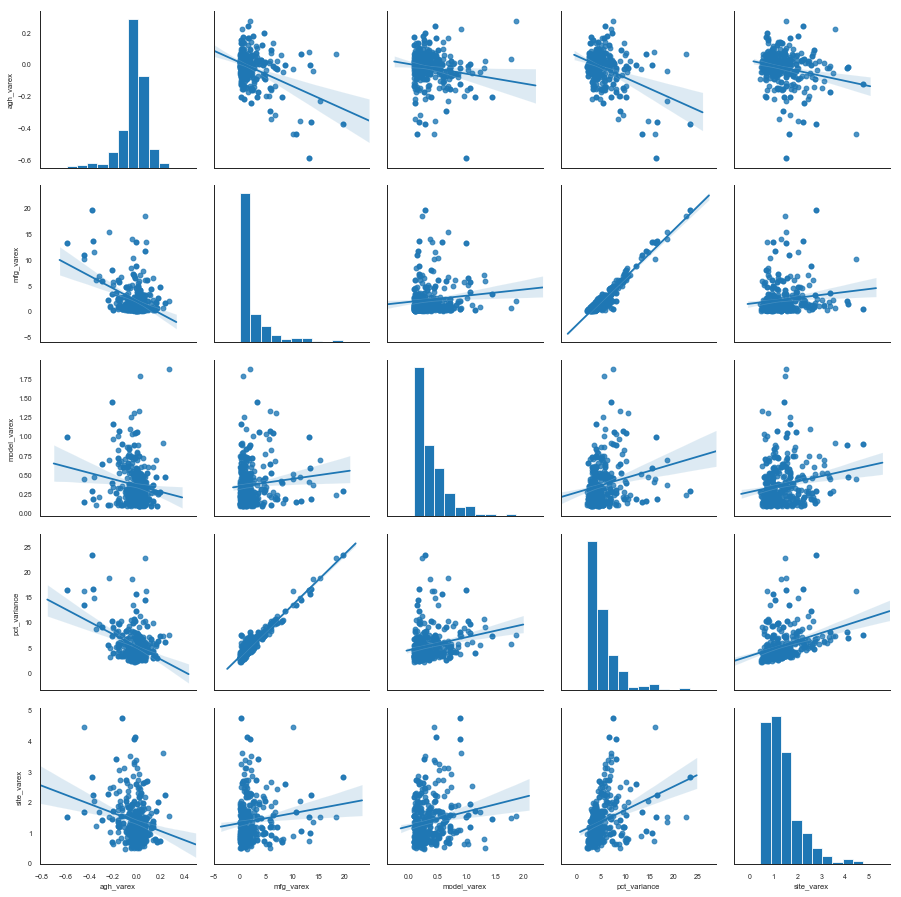

In [16]:
bs_dif_sig_wide = bs_dif_sig.pivot(index='metric', columns='level', values='mean_dif')
sns.pairplot(bs_dif_sig_wide,
            kind='reg')

# Model fit results

In [17]:
alpha = 0.005
qup = 1 - (alpha/2)
qdn = (alpha/2)

In [18]:
mod_names = ['normal', 'age_rsd', 'ab_normal']
cb_mod_names = ['combat', 'cbagersd', 'ab_combat']
test_vals = con_mod_res.groupby(['name', 'pn'])[['ho_score']].mean().reset_index().query('pn == 0').drop('pn',axis=1).set_index('name').values
null_max_vals = con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().query('name in @mod_names').groupby( ['pn'])[['ho_score']].max().values.flatten()
null_min_vals = con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().query('name in @mod_names').groupby( ['pn'])[['ho_score']].min().values.flatten()

In [19]:
con_mod_to_plot = con_mod_res.groupby(['pn', 'name'])[['ho_score']].agg(['mean' ,'std']).query('pn == 0').reset_index()
con_mod_to_plot.columns = [' '.join(col).strip() for col in con_mod_to_plot.columns.values]
con_mod_to_plot = con_mod_to_plot.drop('pn', axis=1)

bs_uncor = bs_collapse.groupby('bal_proc').apply(lambda x: pd.Series(rp.get_bs_stats(alpha, x.ho_score_uncorrected)))
bs_combat = bs_collapse.groupby('bal_proc').apply(lambda x: pd.Series(rp.get_bs_stats(alpha, x.ho_score_combat)))
bs_dif = bs_collapse.groupby('bal_proc').apply(lambda x: pd.Series(rp.get_bs_stats(alpha, x.difference)))

bs_uncor['name'] = [bs_con_mod_res.query('bal_proc == @bp & pn == 0 & ~combat').name.values[0] for bp in bs_uncor.index]
bs_combat['name'] = [bs_con_mod_res.query('bal_proc == @bp & pn == 0 & combat').name.values[0] for bp in bs_combat.index]
bs_mdls = pd.concat([bs_uncor,bs_combat]).rename(columns = {'std_val':'std'})

# substitute in the bootstrap standard deviations instead of the standard deviations across folds and draws
con_mod_to_plot = con_mod_to_plot.merge(bs_mdls.loc[:,['name', 'std']]).drop(columns='ho_score std').rename(columns={'std':'ho_score std'})

con_mod_to_plot['ho_score std'] *= 100
con_mod_to_plot['ho_score mean'] *= 100
con_mod_to_plot['label'] = 'Rest'
#con_mod_to_plot.loc[con_mod_to_plot.contrast.str.contains('condition'), 'label'] = con_mod_to_plot.contrast.str.split('-').str[1:-1].str.join('-').str.title() + '* ' + con_mod_to_plot.run.str.split('.').str[0].str[-1]
#con_mod_to_plot.loc[~con_mod_to_plot.contrast.str.contains('condition'), 'label'] = con_mod_to_plot.contrast.str.replace('contrast', '').str.replace('fixation', 'Fix').str.replace('reward', 'Rewd').str.replace('small', 'Sm').str.replace('large', 'Lg').str.replace('neutral', 'Neut').str.replace('positive', 'Pos').str.replace('negative', 'Neg').str.replace('anticipation', 'Ant').str.replace('-any', '').str.replace('correct', 'cor').str.replace('-of', '').str.split('-').str[1:].str.join(' ').str.title().str.replace('Versus', 'v').str.replace('Feeback', 'FB').str.replace('Feedback', 'FB') + ' ' + con_mod_to_plot.run.str.split('.').str[0].str[-1]

Could not fit GPD to tail of distribution, returning empirical cdf based p.


In [20]:
ps = bs_collapse.groupby('bal_proc').apply(lambda x: pd.Series(rp.get_bs_p(x.difference.values, 0)))

In [21]:
ps.values

array([[1.73226908e-07],
       [3.25235225e-03],
       [3.94533976e-08]])

In [22]:
# p values for comparisons between combat and non-combat corrected for multiple comparisons
multipletests(ps.values.squeeze(), alpha=alpha, method="sidak")

(array([ True, False,  True]),
 array([5.19680633e-07, 9.72535777e-03, 1.18360188e-07]),
 0.0016694521863086509,
 0.0016666666666666668)

In [23]:
wide_df = (con_mod_to_plot.query('name == @mod_names[0]')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":mod_names[0], "ho_score std":mod_names[0]+"_std"})
                          .drop("name", axis=1))
for name in mod_names[1:]:
    tmp = (con_mod_to_plot.query('name == @name')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":name, "ho_score std":name+"_std"})
                          .drop("name", axis=1))
    wide_df = wide_df.merge(tmp, how='left', on=['label'])
    
cb_wide_df = (con_mod_to_plot.query('name == @cb_mod_names[0]')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":cb_mod_names[0], "ho_score std":cb_mod_names[0]+"_std"})
                          .drop("name", axis=1))
for name in cb_mod_names[1:]:
    tmp = (con_mod_to_plot.query('name == @name')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":name, "ho_score std":name+"_std"})
                          .drop("name", axis=1))
    cb_wide_df = cb_wide_df.merge(tmp, how='left', on=['label'])
    
# sig_thresh across normal and combat models 
sig_thresh = {'normal': 100*con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().groupby( ['pn'])[['ho_score']].max().quantile([qup]).values[0][0]}
sig_thresh['combat'] = sig_thresh['normal']
sig_thresh['age_rsd'] = sig_thresh['normal']
sig_thresh['cbagersd'] = sig_thresh['normal']
sig_thresh['ab_normal'] = sig_thresh['normal']
sig_thresh['ab_combat'] = sig_thresh['normal']

sig_thresh


uncor_df = con_mod_res.query('name in @mod_names').loc[:, ['pn', 'fn', 'name', 'ho_score']]
combat_df = con_mod_res.query('name in @cb_mod_names').loc[:, ['pn', 'fn', 'name', 'ho_score']]
combat_df['name'] = combat_df.name.str.replace('combat', 'normal').str.replace('cbagersd', 'age_rsd')
uncb_df = uncor_df.merge(combat_df, how='left', on=['pn', 'fn', 'name'], suffixes=('', '_combat'))
uncb_df['dif'] = uncb_df.ho_score - uncb_df.ho_score_combat

{'normal': 9.578872053872056,
 'combat': 9.578872053872056,
 'age_rsd': 9.578872053872056,
 'cbagersd': 9.578872053872056,
 'ab_normal': 9.578872053872056,
 'ab_combat': 9.578872053872056}

<BarContainer object of 6 artists>

 <BarContainer object of 6 artists>]

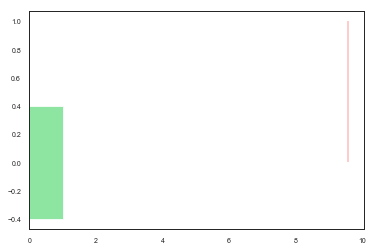

In [24]:
fig,ax = plt.subplots(1)
sig_palette=sns.color_palette('muted')[0:len(mod_names)]
palette=sns.color_palette('pastel')[0:len(mod_names)]
bottom = np.zeros(len(mod_names)*2)
width = np.ones(len(mod_names)*2)
leg_labels = []
colors = []
for i,vf in enumerate(mod_names):
    colors.append(sig_palette[i])
    leg_labels.append('Sig. '+vf)
    leg_labels.append(vf)
    colors.append(palette[i])
ax.barh(bottom, width, color=colors, label=['Sig. Raw', 'Raw','Sig. Age Regressed', 'Age Regressed' ])
ax.vlines(sig_thresh['normal'], 0,2-1, colors = 'r', lw=0.4, label='Multiple Comparison\nCorrected p<0.001')
leg_hand, leg_labels = ax.get_legend_handles_labels()
leg_hand
handles = []
handles.extend(leg_hand[1])
handles.append(leg_hand[0])

labels = ['Sig. Raw', 'Raw', 'Sig. Age Regressed', 'Age Regressed', 'Sig. Age Balanced', 'Age Balanced']
labels.append(leg_labels[0])

In [25]:
leg_reo = [0, 2, 4, 6, 1, 3, 5]
labels = list(np.array(labels)[leg_reo])
handles = list(np.array(handles)[leg_reo])

In [26]:
uncorlist = rp.make_bar_list(mod_names, wide_df, sig_thresh, cols = 1, error=[mn + '_std' for mn in mod_names], stack=False)
cblist = rp.make_bar_list(cb_mod_names, cb_wide_df, sig_thresh, left_start = 43, cols = 1, error=[mn + '_std' for mn in cb_mod_names], stack=False)

In [27]:
sns.set_context('paper', font_scale=0.8)

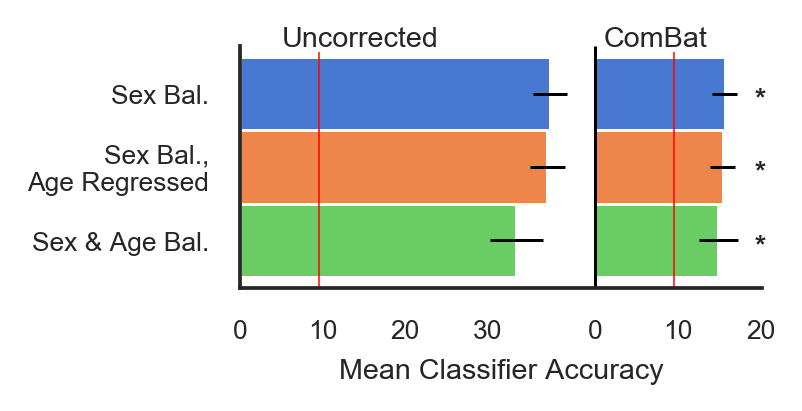

In [28]:

fig, ax = plt.subplots(1, figsize=(3,1.5), dpi=270)

col = 0
for uc, cb in zip(uncorlist, cblist):
    uc = uc.copy()
    cb = cb.copy()
    uc.y = 0 - uc.y
    cb.y = 0 - cb.y
    barh_dict = uc.loc[uc.col == col, ['y', 'color', 'left',  'width', 'height', 'xerr']].to_dict('list')
    cb_barh_dict = cb.loc[cb.col == col, ['y', 'color', 'left', 'width', 'height', 'xerr']].to_dict('list')

    #names = uc.loc[uc.col == col, ['task']]
    _plot = ax.barh(**barh_dict, error_kw={'elinewidth':0.8})
    _plot = ax.barh(**cb_barh_dict, error_kw={'elinewidth':0.8})
#name_df = uc.loc[uc.col == col, ['bottom', 'task']].groupby('task').max().reset_index()
#for ii, row in name_df.iterrows():
#    _text = ax.text(11, row.bottom + 1, row.metric, va='bottom', ha='center')
yb,yt = ax.get_ylim()
#_ylims = ax.set_ylim((np.max(barh_dict['bottom'])-plot_range-1, np.max(barh_dict['bottom'])+2))
_vl = ax.vlines(43, yb,yt, lw=0.8)
_vl = ax.vlines(sig_thresh['normal'], yb,yt-0.02, colors = 'r', lw=0.4)
#_vl = ax.vlines(low_sig_thresh['normal'], yb,yt-0.02, colors = 'r', lw=0.4)

_vl = ax.vlines(43+sig_thresh['combat'], yb,yt-0.02, colors = 'r', lw=0.4)
#_vl = ax.vlines(43+low_sig_thresh['normal'], yb,yt-0.02, colors = 'r', lw=0.4)

_lim = ax.set_ylim((yb,yt))
t = ax.set_xticks([0,10,20,30,43, 53, 63])
_tl = ax.set_xticklabels([0,10,20,30,0, 10, 20])
#_ylims = ax.set_ylim((yb, yt))
_t = ax.text(5, yt, 'Uncorrected')
_t = ax.text(44, yt, 'ComBat')
#_t = ax.set_title(name_df.task.values[0])
_t = ax.set_xlabel('Mean Classifier Accuracy')
_yt = ax.set_yticks(0-pd.concat(uncorlist).y)
_ytl = ax.set_yticklabels(['Sex Bal.', 'Sex Bal.,\nAge Regressed', 'Sex & Age Bal.'])

for yval in (0-pd.concat(uncorlist).y):
    _s = ax.text(63, yval-0.021, '*', va='center', ha='center', fontweight='bold')

fig.tight_layout()
#_leg = fig.legend(handles, labels, ncol=2 , loc=(0.6,0.5))    
#fig.subplots_adjust(bottom = 0.12)

sns.despine(fig)

Classifier Performance Before and After ComBat for Resting State Functional Connectivity

Bars show mean classifier performance across 3 fold cross-validation for raw and age regressed data and split half cross-vaidation for age balanced data from 25 sex balanced draws for resting state functional connetivity metrics. Error bars indicate standard error of the mean from 1000 bootstrap resamplings. We ran 1000 permutations balanced across gender, handedness and age in 3 month bins to determine chance classifier performance. The red line indicates the multiple comparison corrected p < 0.002 threshold from these permutations. All classifiers had greater accuracy than this cut-off. Classifier performance on data with no corrections for age are shown in blue. Green bars show classifier performance in which the effect of age learned on the training split within each cross validation fold was regressed out of each ROI. Red bars show classifier performance using a restricted dataset in which we drew samples balanced for gender and age in six month bins from each site. The uncorrected columns show results without running ComBat to correct for site effects. The ComBat columns show classifier performance after correcting for site effects with ComBat based on parameters learned from the training split within each cross validation. Astrices indicate significant reduction in classifier accuracy with p < 0.002 as determined by boostrap resampling.

# Look at confusion matrix

In [29]:
alpha = 0.05
qup = 1 - (alpha/2)
qdn = (alpha/2)


In [30]:
raw_df = pd.read_pickle('swarm_dir_bs/big_con.pkz')
with open('swarm_dir_bs/yfit_con.pkz', 'rb') as h:
    ymapper = pickle.load(h)

In [31]:
raw_df['cat_num'] = ymapper.transform(raw_df)


In [32]:
model_lut = {k:v['mri_info_manufacturersmn'] for k,v in  raw_df.groupby('cat_num')[['mri_info_manufacturersmn']].first().to_dict('index').items()}
mfg_lut = {k:v['mri_info_manufacturer'] for k,v in  raw_df.groupby('cat_num')[['mri_info_manufacturer']].first().to_dict('index').items()}

model_order = ['DISCOVERY MR750','Achieva dStream', 'Ingenia', 'Prisma', 'Prisma_fit', ]

mfg_order = ['GE MEDICAL SYSTEMS', 'Philips Medical Systems', 'SIEMENS', ]

In [33]:
cfns, perm_cfns = rp.get_cfns(con_mod_res, 'normal')
ab_cfns, ab_perm_cfns = rp.get_cfns(con_mod_res, 'ab_normal')
cb_cfns, cb_perm_cfns = rp.get_cfns(con_mod_res, 'combat')


In [34]:
bs_cfns, bs_perm_cfns = rp.get_cfns(bs_con_mod_res, 'normal', include0=True)
#bs_ab_cfns, bs_ab_perm_cfns = get_cfns(bs_con_mod_res, 'ab_normal', include0=True)
bs_cb_cfns, bs_cb_perm_cfns = rp.get_cfns(bs_con_mod_res, 'combat', include0=True)


In [35]:
model_inds = rp.invert_lut(model_lut)
mfg_inds = rp.invert_lut(mfg_lut)
bs_mdl_cfns = rp.collapse_cfn(bs_perm_cfns, model_inds, model_order)
bs_mfg_cfns = rp.collapse_cfn(bs_perm_cfns, mfg_inds, mfg_order)
bs_cb_mdl_cfns = rp.collapse_cfn(bs_cb_perm_cfns, model_inds, model_order)
bs_cb_mfg_cfns = rp.collapse_cfn(bs_cb_perm_cfns, mfg_inds, mfg_order)

bs_perm_dif = rp.normalize_cfn(bs_cb_perm_cfns) - rp.normalize_cfn(bs_perm_cfns)
bs_mdl_dif = rp.normalize_cfn(bs_cb_mdl_cfns) - rp.normalize_cfn(bs_mdl_cfns)
bs_mfg_dif = rp.normalize_cfn(bs_cb_mfg_cfns) - rp.normalize_cfn(bs_mfg_cfns)

In [36]:
bs_dif_res = rp.get_bs_res(bs_perm_dif, alpha, side='double')
bs_mdl_dif_res = rp.get_bs_res(bs_mdl_dif, alpha, side='double')
bs_mfg_dif_res = rp.get_bs_res(bs_mfg_dif, alpha, side='double')

/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/data/nielsond/python/envs/abcd_mine/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [37]:
cfn_signed_ps = rp.get_cfn_sig(cfns, perm_cfns)
ab_cfn_signed_ps = rp.get_cfn_sig(ab_cfns, ab_perm_cfns)
cb_cfn_signed_ps = rp.get_cfn_sig(cb_cfns, cb_perm_cfns)

In [38]:
model_cfns, mfg_cfns, model_cfn_signed_ps_norm, mfg_cfn_signed_ps_norm = rp.get_collapsed_perms(cfns, perm_cfns, model_lut, model_order, mfg_lut, mfg_order)
#ab_model_cfns, ab_mfg_cfns, ab_model_cfn_signed_ps_norm, ab_mfg_cfn_signed_ps_norm = get_collapsed_perms(ab_cfns, ab_perm_cfns, model_lut, model_order, mfg_lut, mfg_order)
cb_model_cfns, cb_mfg_cfns, cb_model_cfn_signed_ps_norm, cb_mfg_cfn_signed_ps_norm = rp.get_collapsed_perms(cb_cfns, cb_perm_cfns, model_lut, model_order, mfg_lut, mfg_order)

In [39]:
cat_df = raw_df.groupby('cat_num')[['mri_info_manufacturer',
                 'mri_info_manufacturersmn',
                 'unique_scanner']].first()
cat_df['mfg'] = cat_df.mri_info_manufacturer
cat_df.loc[cat_df.mri_info_manufacturer.str.contains('GE'), 'mfg'] = 'GE'
cat_df.loc[cat_df.mri_info_manufacturer.str.contains('Philips'), 'mfg'] = 'PH'
cat_df.loc[cat_df.mri_info_manufacturer.str.contains('SIEMENS'), 'mfg'] = 'SM'

cat_df['mdl'] = cat_df.mri_info_manufacturersmn
cat_df.loc[cat_df.mri_info_manufacturersmn == 'Prisma', 'mdl'] = 'Prsm'
cat_df.loc[cat_df.mri_info_manufacturersmn == 'Prisma_fit', 'mdl'] = 'Pr-f'
cat_df.loc[cat_df.mri_info_manufacturersmn == 'DISCOVERY MR750', 'mdl'] = 'Dsc7'
cat_df.loc[cat_df.mri_info_manufacturersmn == 'Ingenia', 'mdl'] = 'Ingn'
cat_df.loc[cat_df.mri_info_manufacturersmn == 'Achieva dStream', 'mdl'] = 'Achv'

cat_df['num'] = cat_df.groupby(['mri_info_manufacturer', 'mri_info_manufacturersmn']).transform(lambda x:np.arange(len(x))).mdl.values

In [40]:
cat_df['hname'] = cat_df.mfg + '_' +cat_df.mdl + '_' + cat_df.num.astype('str')

In [41]:
cat_df['sort_key'] = 0
cat_df.loc[cat_df.mfg == 'GE', 'sort_key'] = 1
cat_df.loc[cat_df.mfg == 'SM',  'sort_key'] = 2

In [42]:
reo_ind = [cat_df.sort_values(['sort_key', 'mri_info_manufacturer',
                  'mri_info_manufacturersmn','num']).reset_index().cat_num.values][0]
classes = cat_df.sort_values(['sort_key', 'mri_info_manufacturer',
                  'mri_info_manufacturersmn','num']).hname.values

In [43]:
mdl_labels = ['Discovery\nMR750', 'Achieva\ndStream', 'Ingenia', 'Prisma', 'Prisma_fit']
mfg_labels = ['GE', 'Philips', 'Siemens']

Normalized confusion matrix
[[0.75207921 0.07366337 0.05306931 0.02178218 0.02534653 0.02376238
  0.00435644 0.00356436 0.00673267 0.0019802  0.02138614 0.01227723]
 [0.12079208 0.71564356 0.02811881 0.02930693 0.02693069 0.01782178
  0.01108911 0.00435644 0.00871287 0.00752475 0.0190099  0.01069307]
 [0.02613861 0.01108911 0.36277228 0.15485149 0.1180198  0.05742574
  0.03445545 0.03960396 0.04079208 0.03960396 0.08475248 0.03049505]
 [0.0229703  0.02574257 0.16752475 0.32039604 0.13623762 0.05227723
  0.02811881 0.0360396  0.05386139 0.0550495  0.05821782 0.04356436]
 [0.02336634 0.02376238 0.12594059 0.12237624 0.41663366 0.07049505
  0.0249505  0.02891089 0.02970297 0.03960396 0.05861386 0.03564356]
 [0.00831683 0.01544554 0.05188119 0.04990099 0.05029703 0.26257426
  0.08356436 0.10732673 0.05544554 0.11366337 0.1350495  0.06653465]
 [0.00990099 0.01069307 0.02138614 0.01425743 0.01465347 0.06732673
  0.27207921 0.12950495 0.10653465 0.11049505 0.0990099  0.14415842]
 [0.01267327 

(None,
 <matplotlib.image.AxesImage at 0x2b9af4011c50>)

Normalized confusion matrix
[[0.83108911 0.09227723 0.07663366]
 [0.04435644 0.64158416 0.31405941]
 [0.02359264 0.09425743 0.88214993]]


(None,
 <matplotlib.image.AxesImage at 0x2b9af403a828>)

Normalized confusion matrix
[[0.23564356 0.13267327 0.0950495  0.08237624 0.08039604 0.0590099
  0.05029703 0.05584158 0.05623762 0.04712871 0.05742574 0.04792079]
 [0.14019802 0.18455446 0.11287129 0.06257426 0.09148515 0.06613861
  0.07326733 0.04673267 0.05346535 0.05663366 0.05861386 0.05346535]
 [0.0950495  0.08950495 0.19485149 0.11643564 0.11247525 0.0570297
  0.04514851 0.07168317 0.04831683 0.04910891 0.07168317 0.04871287]
 [0.09148515 0.07524752 0.14336634 0.14732673 0.12554455 0.06376238
  0.04594059 0.06415842 0.06257426 0.06930693 0.0590099  0.05227723]
 [0.09267327 0.0950495  0.1390099  0.11326733 0.17465347 0.06574257
  0.05386139 0.04910891 0.04673267 0.0570297  0.06376238 0.04910891]
 [0.07089109 0.08118812 0.09386139 0.08435644 0.08950495 0.13306931
  0.07643564 0.07762376 0.04475248 0.08950495 0.07920792 0.07960396]
 [0.06138614 0.06693069 0.05425743 0.05623762 0.06534653 0.07009901
  0.15168317 0.08       0.08118812 0.12871287 0.0629703  0.12118812]
 [0.06891089 0.

(None,
 <matplotlib.image.AxesImage at 0x2b9af40be9b0>)

Normalized confusion matrix
[[0.34653465 0.26237624 0.39108911]
 [0.17966997 0.42231023 0.3980198 ]
 [0.1397454  0.21148515 0.64876945]]


(None,
 <matplotlib.image.AxesImage at 0x2b9af40cda90>)

Confusion matrix, without normalization
[[-5.34644299e-01  4.99024511e-02  4.34512848e-02  6.31640557e-02
   5.41448098e-02  3.72736571e-02  4.80500239e-02  4.91651610e-02
   5.36561421e-02  4.90106203e-02  3.49085710e-02  5.19175221e-02]
 [-2.04491234e-04 -5.28471760e-01  7.08491267e-02  5.05578947e-02
   6.43644530e-02  4.62399099e-02  6.25280620e-02  4.78885392e-02
   4.88293786e-02  5.14977949e-02  4.08679628e-02  4.50531295e-02]
 [ 5.42532362e-02  7.12036331e-02 -1.67648707e-01 -3.22224756e-02
  -1.18203551e-02  6.04023561e-03  2.44182424e-02  2.31934011e-02
   1.05056173e-02  1.56046902e-02 -5.44151016e-03  1.19139918e-02]
 [ 6.39485516e-02  4.87084302e-02 -3.35685891e-02 -1.44956104e-01
  -2.03872000e-02  2.49988367e-03  2.23231322e-02  1.86860360e-02
   1.49184803e-02  1.15087121e-02  6.76971154e-03  9.54895571e-03]
 [ 5.95815093e-02  6.49175258e-02 -7.00277040e-03  1.34690751e-05
  -2.53261610e-01  3.96899612e-03  3.35036905e-02  2.49436769e-02
   2.64575372e-02  1.88836156e-0

(None,
 <matplotlib.image.AxesImage at 0x2b9af40fca58>)

Confusion matrix, without normalization
[[-0.50670905  0.17326581  0.33344324]
 [ 0.12087096 -0.22361811  0.10274715]
 [ 0.11416225  0.11602148 -0.23018372]]


(None,
 <matplotlib.image.AxesImage at 0x2b9af4117080>)

Text(0.5,147.833,'Proportion')

Text(0.5,147.833,'Proportion')

Text(0.5,147.833,'Change in Proportion')

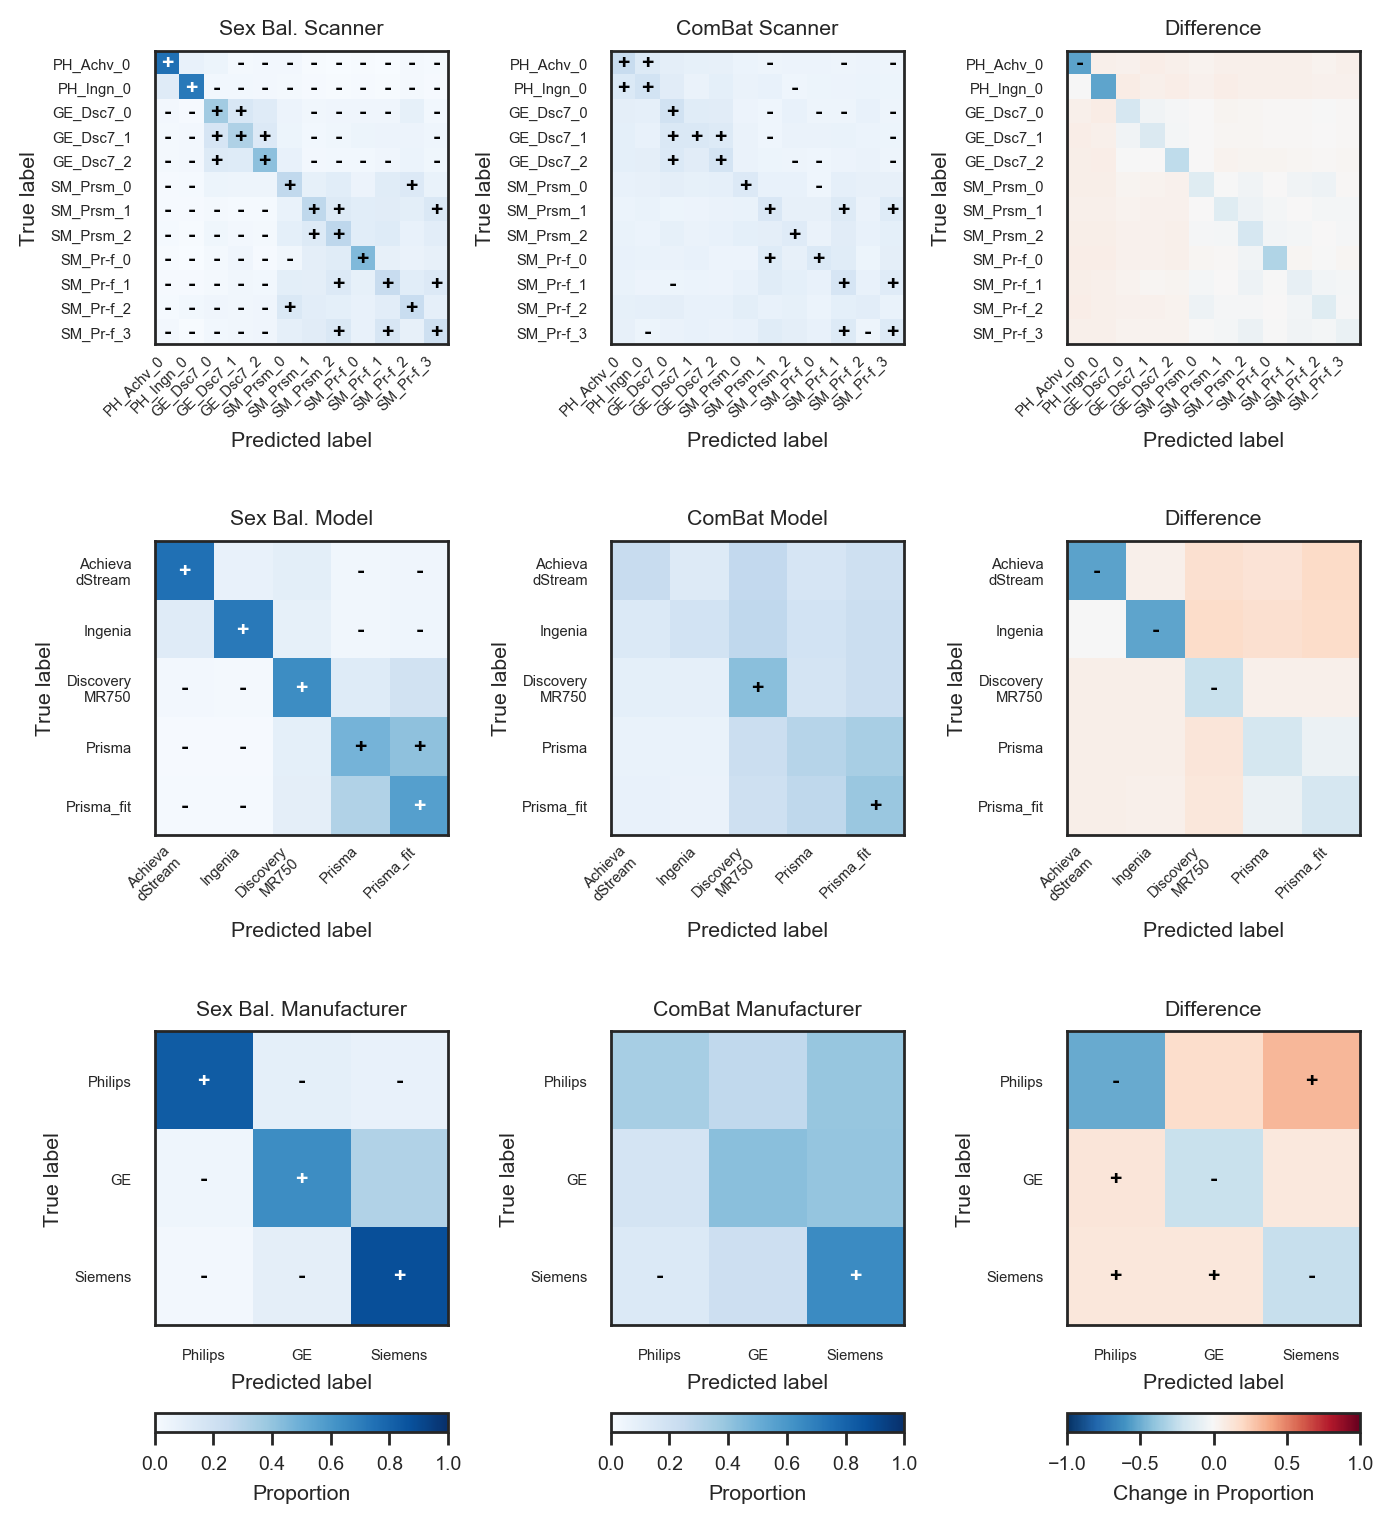

In [44]:
sns.set_context('paper', font_scale = 0.8)
#fig,axes = plt.subplots(3,1, figsize = (, 11), dpi = 100)
fig = plt.figure(figsize = (7, 8), dpi = 200)
gs = gridspec.GridSpec(4,3, height_ratios=[8,8,8,0.5])
axes = [plt.subplot(g) for g in gs]

# Raw
_fig,_ax,im0 = rp.plot_confusion_matrix(cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="Sex Bal. Scanner",
                      signed_ps = cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[0], fig=fig, sig_thresh=alpha/2, symbols=True)

labels = axes[0].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
model_cfn = model_cfns.mean(0)
model_reo = [1,2,0,3,4]
rp.plot_confusion_matrix(model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="Sex Bal. Model",
                      signed_ps = model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[3], sig_thresh=alpha/2, symbols=True)
labels = axes[3].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_cfn = mfg_cfns.mean(0)
mfg_reo = [1,0,2]
rp.plot_confusion_matrix(mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="Sex Bal. Manufacturer",
                      signed_ps = mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo],  colorbar=False, ax=axes[6], sig_thresh=alpha/2, symbols=True)
#axes[0].figure.tight_layout()

# Combat
_fig,_ax,im1 = rp.plot_confusion_matrix(cb_cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="ComBat Scanner",
                      signed_ps = cb_cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[1], fig=fig, sig_thresh=alpha/2, symbols=True)

labels = axes[1].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
cb_model_cfn = cb_model_cfns.mean(0)
model_reo = [1,2,0,3,4]
rp.plot_confusion_matrix(cb_model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="ComBat Model",
                      signed_ps = cb_model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[4], sig_thresh=alpha/2, symbols=True)
labels = axes[4].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
cb_mfg_cfn = cb_mfg_cfns.mean(0)
rp.plot_confusion_matrix(cb_mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="ComBat Manufacturer",
                      signed_ps = cb_mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo], colorbar=False, ax=axes[7], sig_thresh=alpha/2, symbols=True)
#axes[0].figure.tight_layout()
#fig.tight_layout()



#Difference
_fig,_ax,im2 = rp.plot_confusion_matrix(bs_dif_res['bs_mean'][reo_ind,:][:,reo_ind],
                                     classes,
                                     normalize=False, numbers=False,
                                     title="Difference",
                                     signed_ps = bs_dif_res['bs_signed_ps'][reo_ind,:][:,reo_ind],
                                     cmap=plt.cm.RdBu_r, colorbar=False,
                                     ax=axes[2], fig=fig,
                                     sig_thresh=alpha, symbols=True,
                                     vmin=-1, vmax=1)

labels = axes[2].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
model_reo = [1,2,0,3,4]
rp.plot_confusion_matrix(bs_mdl_dif_res['bs_mean'][model_reo, :][:, model_reo],
                      np.array(mdl_labels)[model_reo], 
                      normalize=False, numbers=False, 
                      title="Difference",
                      signed_ps = bs_mdl_dif_res['bs_signed_ps'][model_reo, :][:, model_reo], 
                      cmap=plt.cm.RdBu_r, colorbar=False,
                      ax=axes[5],
                      sig_thresh=alpha, symbols=True,
                                     vmin=-1, vmax=1)
labels = axes[5].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]

rp.plot_confusion_matrix(bs_mfg_dif_res['bs_mean'][mfg_reo, :][:, mfg_reo],
                      np.array(mfg_labels)[mfg_reo],
                      normalize=False, numbers=False,
                      title="Difference",
                      signed_ps = bs_mfg_dif_res['bs_signed_ps'][mfg_reo, :][:, mfg_reo],
                      cmap=plt.cm.RdBu_r, colorbar=False, ax=axes[8],
                      sig_thresh=alpha, symbols=True,
                                     vmin=-1, vmax=1)

fig.tight_layout()

fig.colorbar(im0, cax = axes[9], orientation='horizontal')
axes[9].set_xlabel('Proportion')
axes[9].set_aspect(0.065)
cbbox = axes[9].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[9].set_position(cbbox)

fig.colorbar(im1, cax = axes[10], orientation='horizontal')
axes[10].set_xlabel('Proportion')
axes[10].set_aspect(0.065)
cbbox = axes[10].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[10].set_position(cbbox)

fig.colorbar(im2, cax = axes[11], orientation='horizontal',ticks=[-1, -0.5, 0, 0.5, 1])
axes[11].set_xlabel('Change in Proportion')
axes[11].set_aspect(0.065)
cbbox = axes[11].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[11].set_position(cbbox)


## Does combat reduce classifiabiilty for all sites

In [45]:
rp.get_bs_res(np.diagonal(bs_perm_dif, axis1=2, axis2=3), alpha=alpha)

{'bs_mean': array([-0.302987  , -0.11793708, -0.16764871, -0.07935444, -0.1449561 ,
        -0.25326161, -0.12390114, -0.16983846, -0.5346443 , -0.52847176,
        -0.1172014 , -0.06947445]),
 'bs_std': array([0.10017316, 0.08484827, 0.09109623, 0.0819137 , 0.08897711,
        0.09221837, 0.08472977, 0.08776872, 0.09438649, 0.10126539,
        0.07753502, 0.07671954]),
 'bs_sign': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 'bs_uncorrected_p': array([2.81612719e-03, 2.27544910e-01, 8.18363273e-02, 4.25149701e-01,
        1.55688623e-01, 1.07975269e-02, 1.87624750e-01, 6.18762475e-02,
        7.67348309e-06, 1.30964175e-03, 1.69660679e-01, 4.81037924e-01]),
 'bs_p': array([3.32749908e-02, 9.54868593e-01, 6.41043956e-01, 9.98697862e-01,
        8.68770432e-01, 1.22145941e-01, 9.17380949e-01, 5.35354661e-01,
        9.20779109e-05, 1.56029931e-02, 8.92584425e-01, 9.99618383e-01]),
 'bs_sig': array([ True, False, False, False, False, False, False, False,  True,
 

No, only sig for 3 sites

# Classifiability by manufacturer

In [46]:
ge_ph = rp.normalize_cfn(bs_mfg_cfns)[:,:,0,0] - rp.normalize_cfn(bs_mfg_cfns)[:,:,1,1]
ge_si = rp.normalize_cfn(bs_mfg_cfns)[:,:,0,0] - rp.normalize_cfn(bs_mfg_cfns)[:,:,2,2]
ph_si = rp.normalize_cfn(bs_mfg_cfns)[:,:,1,1] - rp.normalize_cfn(bs_mfg_cfns)[:,:,2,2]

In [47]:
multipletests([rp.get_bs_p(x) for x in [ge_ph, ge_si, ph_si]], alpha=alpha, method='sidak')

(array([ True,  True, False]),
 array([0.01490288, 0.00169359, 0.68468113]),
 0.016952427508441503,
 0.016666666666666666)